In [2]:
!pip install pandas
!pip install scikit-posthocs

  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
  Using cached scikit_posthocs-0.8.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached statsmodels-0.14.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.5 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.7.5-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.7 kB)
  Using cached contourpy-1.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata

In [3]:
import pandas as pd
from scipy import stats
import scikit_posthocs as sp
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("accuracy_scores.csv")

In [5]:
df = df.drop(columns=["perc_pred_missing"])

In [6]:
df.head()
# with exception of r2, the rest are losses meaning the larger the value, the worse it is

dataset  \
0            air_quality_kdd_2018_ratio_2   
1              airline_passengers_ratio_2   
2  atmospheric_co2_concentrations_ratio_2   
3      australian_beer_production_ratio_2   
4                   avocado_sales_ratio_2   

                                 model      rmse   rmsse       mae    mase  \
0  rt_forecasting_darts_naive_seasonal   76.6760  0.6887   57.2574  0.5900   
1  rt_forecasting_darts_naive_seasonal   50.7083  0.5731   47.8333  0.7487   
2  rt_forecasting_darts_naive_seasonal    2.5894  0.8282    2.5058  1.0000   
3  rt_forecasting_darts_naive_seasonal   12.0830  0.3145   10.2500  0.3453   
4  rt_forecasting_darts_naive_seasonal  373.2930  1.0502  325.2244  1.0735   

     smape     wape      r2  
0  69.2907  89.1349  0.0199  
1  10.5718  10.0455  0.9551  
2   0.5971   0.5954  0.8783  
3   2.4575   2.4075  0.9048  
4  34.0507  30.3228  0.0995

airline_passengers_ratio_4: the total number of observations in training history is four times the length of the forecast period. The total number of observations in the dataset, including training and test splits, is 5x the forecast length.

The characteristic is that ratio (2,4,6,8,10,max). Try the Friedman test followed by Nemenyi. 

In [33]:
def mean_confidence_interval(data, confidence=(1-alpha)):
    n = len(data)
    mean = np.mean(data)
    se = stats.sem(data)  # Standard error
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)  # Margin of error
    return mean, mean-h, mean+h

def generate_scores(method, method_args, data, labels):
    pairwise_scores = method(data, **method_args) # Matrix for all pairwise comaprisons
    
    pairwise_scores = pairwise_scores.set_axis(axis='columns',labels=labels)
        
    pairwise_scores = pairwise_scores.set_axis(axis='rows',labels=labels)
    
    return pairwise_scores

def plot(scores):
    # Pretty plot of significance
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'square': True,
                    'cbar_ax_bbox': [-.1, -.1, 0.04, 0.1]}

    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size as needed
    sp.sign_plot(scores, **heatmap_args)
    
    # Ensure all labels are shown
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)

    plt.title('Posthoc Nemenyi Test Results')
    plt.show()
    
def specific_plot(scores, method_list, alpha=.1):
    heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'square': True,
                    'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
    sig_array = sp.sign_array(scores, alpha)
    sig_array =sig_array.astype(int)
    fig, ax = plt.subplots(figsize=(10, 10))
    sp.sign_plot(sig_array, g=method_list,flat=True,**heatmap_args)
    plt.show()

def compare(method1, method2, stats_df, nemenyi_scores):
    means = stats_df.apply(np.mean)
    means_dict = means.to_dict()
    # we are working with loss so the larger the value, the worse it is
    winner = ""
    loser = ""
    if means_dict[method1] > means_dict[method2]:
        # print(method1 + " performs worse than " + method2)
        winner = method2
        loser = method1
    else:
        # print(method2 + " performs worse than " + method1)
        winner = method1
        loser = method2
    p_value = nemenyi_scores[method1][method2]
    if p_value < .1:
        # print("There is statistical significance")
        return {"winner": winner, "loser": loser}
    else:
        # print("No statistical significance")
        return -1

def generate_stats(df, ratio, metric, alpha):
    filtered_df = df[df['dataset'].str.endswith(ratio)]
    datasets = list(set(filtered_df["dataset"]))
    algorithms = list(set(filtered_df["model"]))

    new_dict = {"dataset": datasets}
    for algorithm in algorithms:
        new_dict[algorithm] = []

    for dataset in datasets:
        for algorithm in algorithms:
            value_series = filtered_df.loc[(filtered_df['dataset'] == dataset) & (filtered_df['model'] == algorithm), metric]
            if len(value_series) == 0:
                #print(dataset)
                #print(algorithm)
                #print("\n")
                value = 0
            else:
                value = value_series.iloc[0]
            new_dict[algorithm].append(value)

    stats_df = pd.DataFrame(new_dict)
    stats_df = stats_df.drop(["dataset"],axis=1)

    means = stats_df.apply(np.mean)
    conf_intervals = stats_df.apply(mean_confidence_interval)

    ci_lower = conf_intervals.apply(lambda x: x[1])
    ci_upper = conf_intervals.apply(lambda x: x[2])

    error_bars = means - ci_lower

    sorted_df = pd.DataFrame({'mean': means, 'error': error_bars})
    sorted_df = sorted_df.sort_values(by='mean')

    fig, ax = plt.subplots(figsize=(12, 6))  
    bars = ax.bar(sorted_df.index, sorted_df['mean'], yerr=sorted_df['error'], capsize=5, color='skyblue')

    ax.set_xlabel('Algorithm')
    ax.set_ylabel('Mean Values')
    ax.set_title('Mean metric: ' + metric + ' Bar Chart with Confidence Intervals Using Ratio: ' + ratio)

    plt.xticks(rotation=90)

    plt.show()

    data = np.asarray(stats_df)

    stat, p = stats.friedmanchisquare(*data)

    reject = p <= alpha
    print("Should we reject H0 (i.e. is there a difference in the means) at the", (1-alpha)*100, "% confidence level?", reject)

    if reject:

        nemenyi_scores = generate_scores(sp.posthoc_nemenyi_friedman, {}, data, stats_df.columns)
        
        # plot(nemenyi_scores)

        specific_plot(nemenyi_scores, list(stats_df.columns), alpha=alpha)

        algorithm_combinations = combinations(algorithms, 2)

    winner_counter_dict = {}
    for algorithm in algorithms:
        winner_counter_dict[algorithm] = 0

    for comb in algorithm_combinations:
        result = compare(comb[0],comb[1], stats_df, nemenyi_scores) 
        if result != -1:
            winner_counter_dict[result["winner"]] += 1

    sorted_data = dict(sorted(winner_counter_dict.items(), key=lambda item: item[1]))

    keys = list(sorted_data.keys())
    values = list(sorted_data.values())

    plt.figure(figsize=(15, 10))
    plt.barh(keys, values, color='skyblue')
    plt.ylabel('Algorithms')
    plt.xlabel('# of times the algorithm is statistically significantly better than another algorithm')
    plt.show()

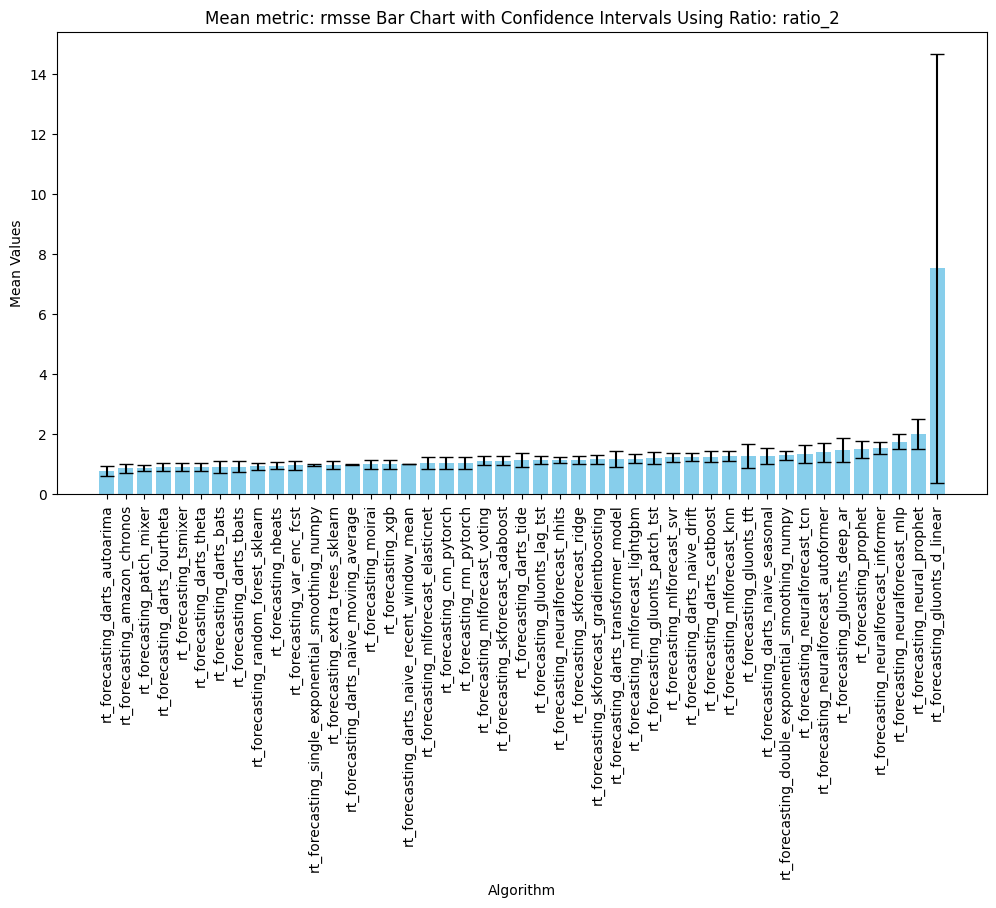

Should we reject H0 (i.e. is there a difference in the means) at the 90.0 % confidence level? True


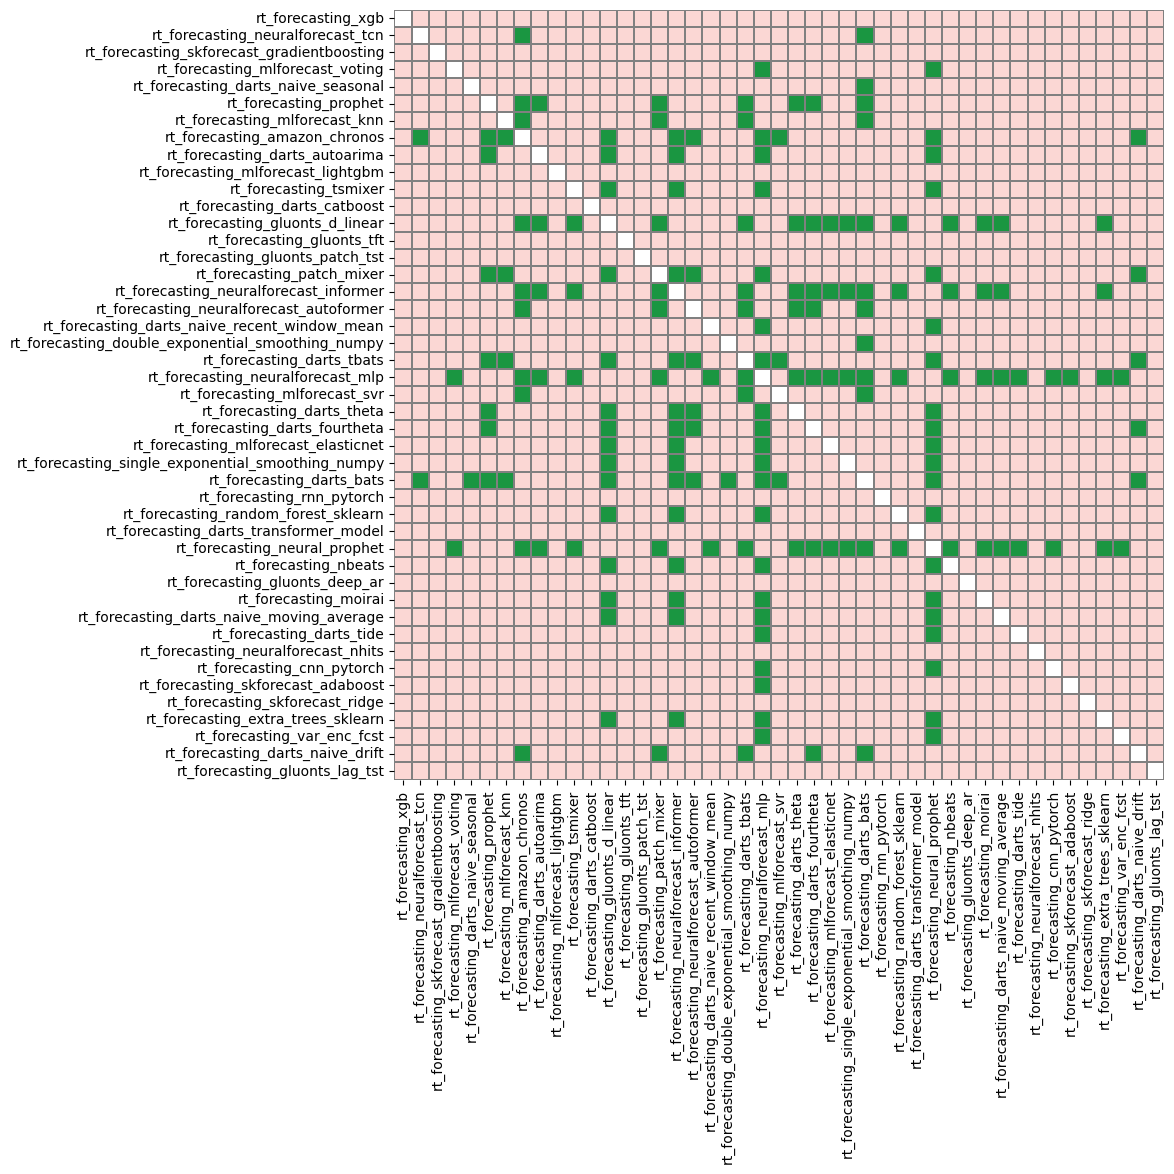

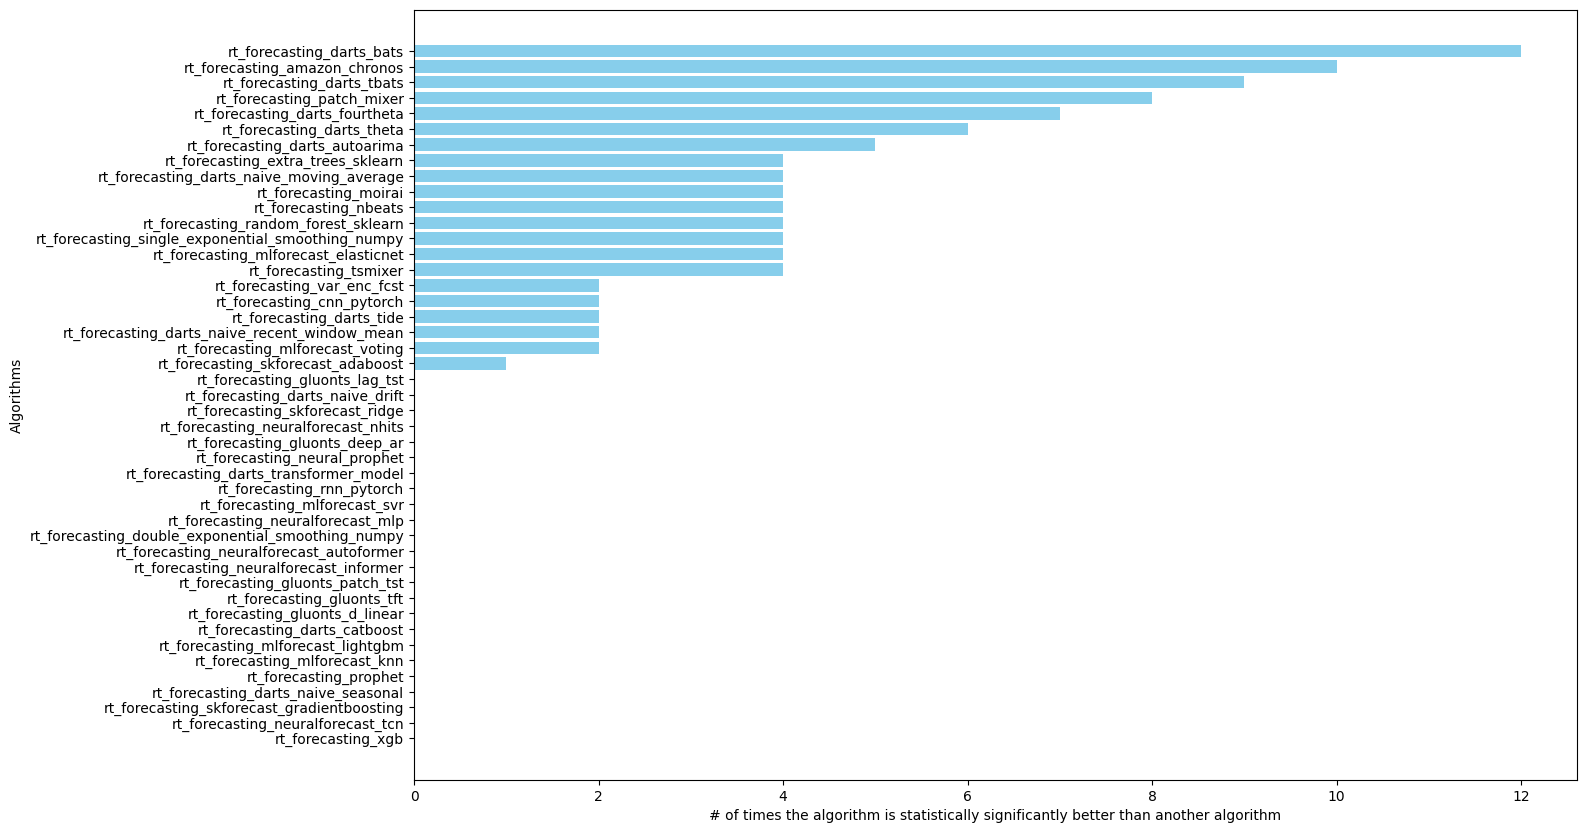

In [34]:
ratio = "ratio_2"
metric = "rmsse"
alpha= .1

generate_stats(df, ratio, metric, alpha)

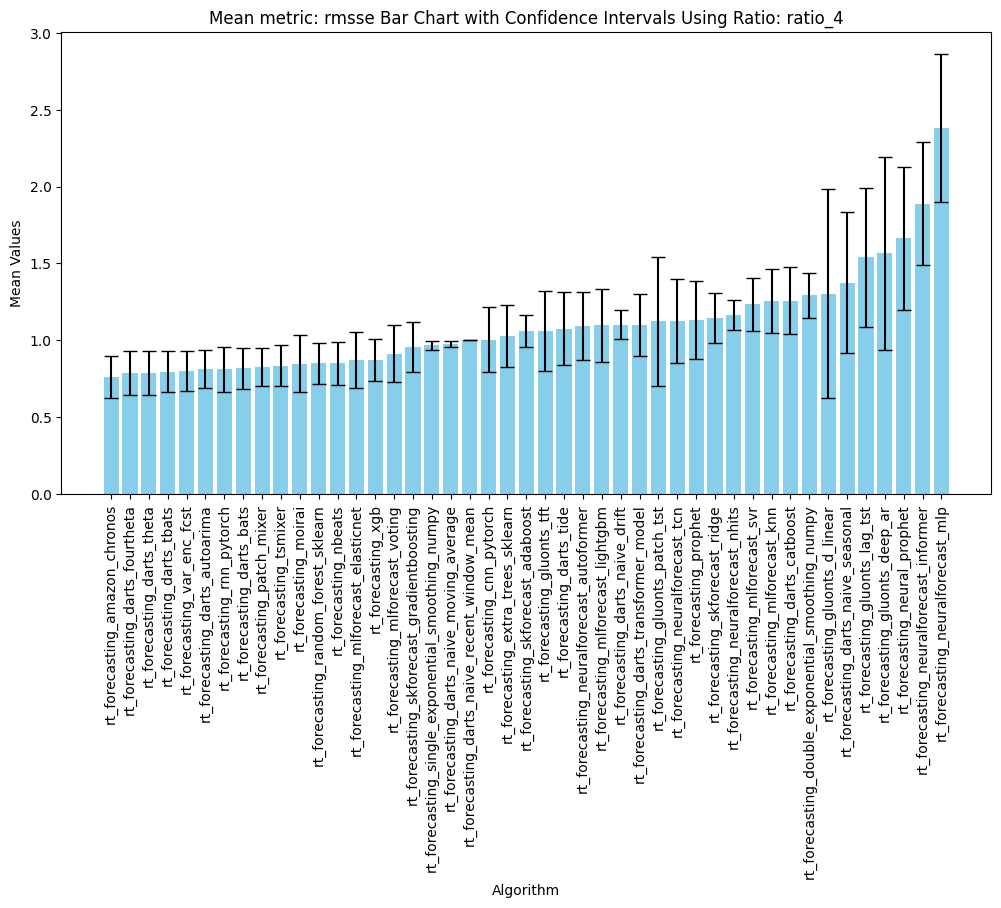

Should we reject H0 (i.e. is there a difference in the means) at the 90.0 % confidence level? True


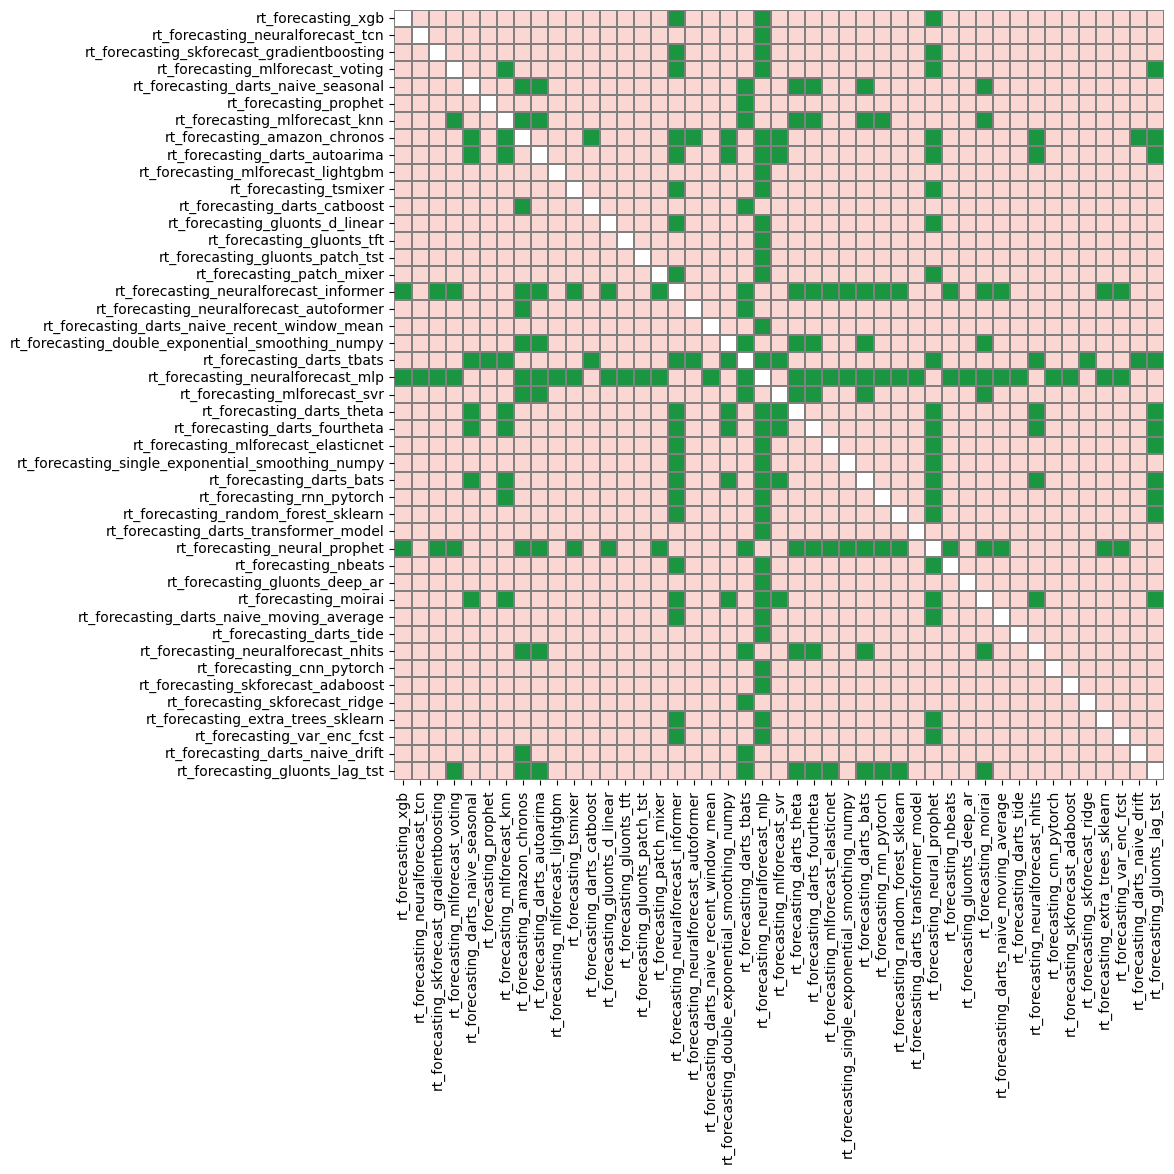

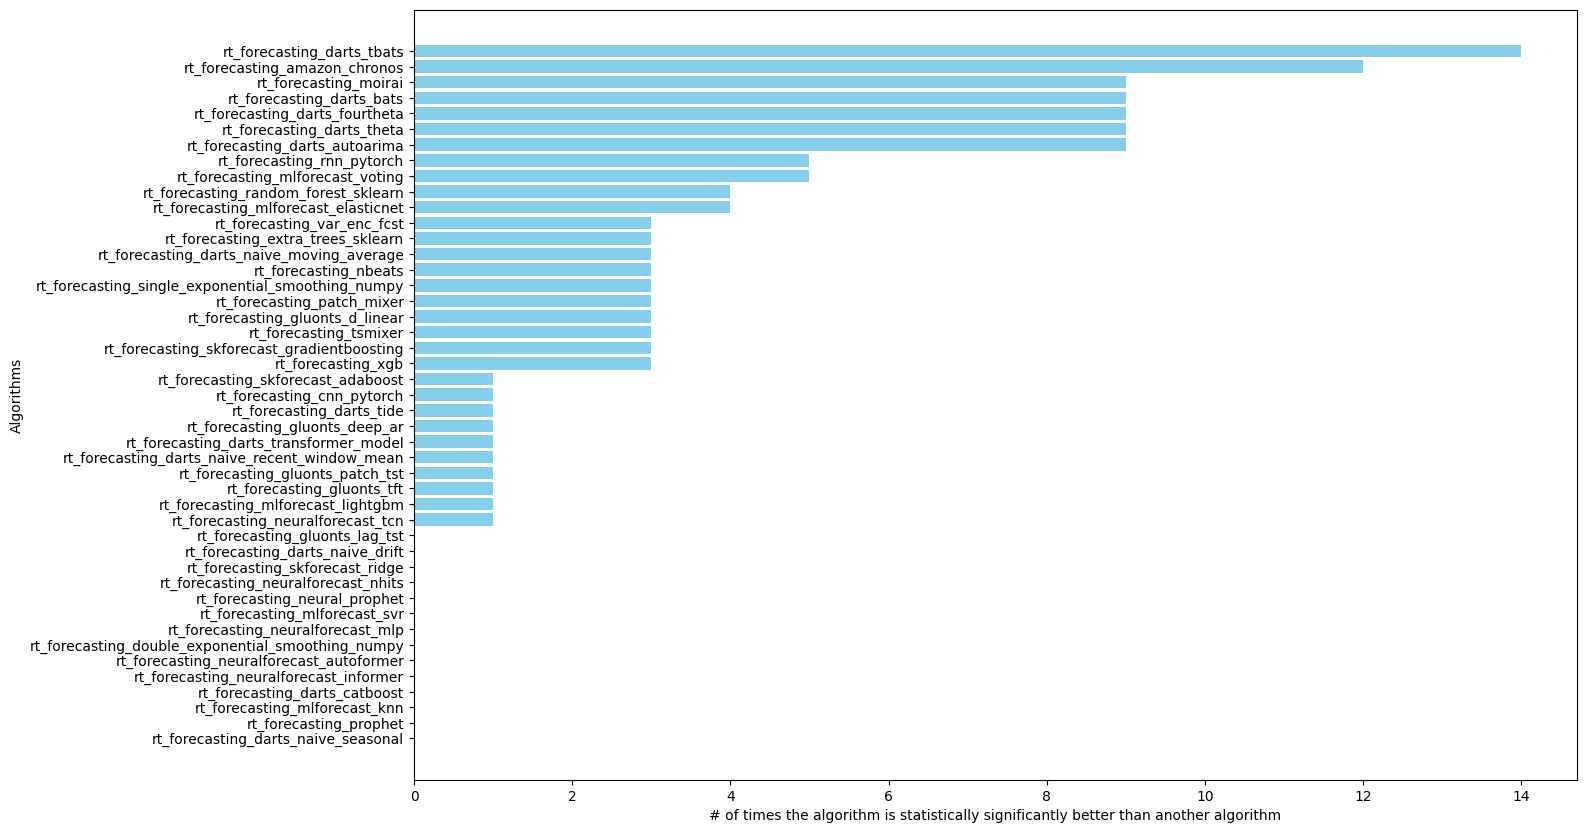

In [35]:
ratio = "ratio_4"
metric = "rmsse"
alpha= .1

generate_stats(df, ratio, metric, alpha)

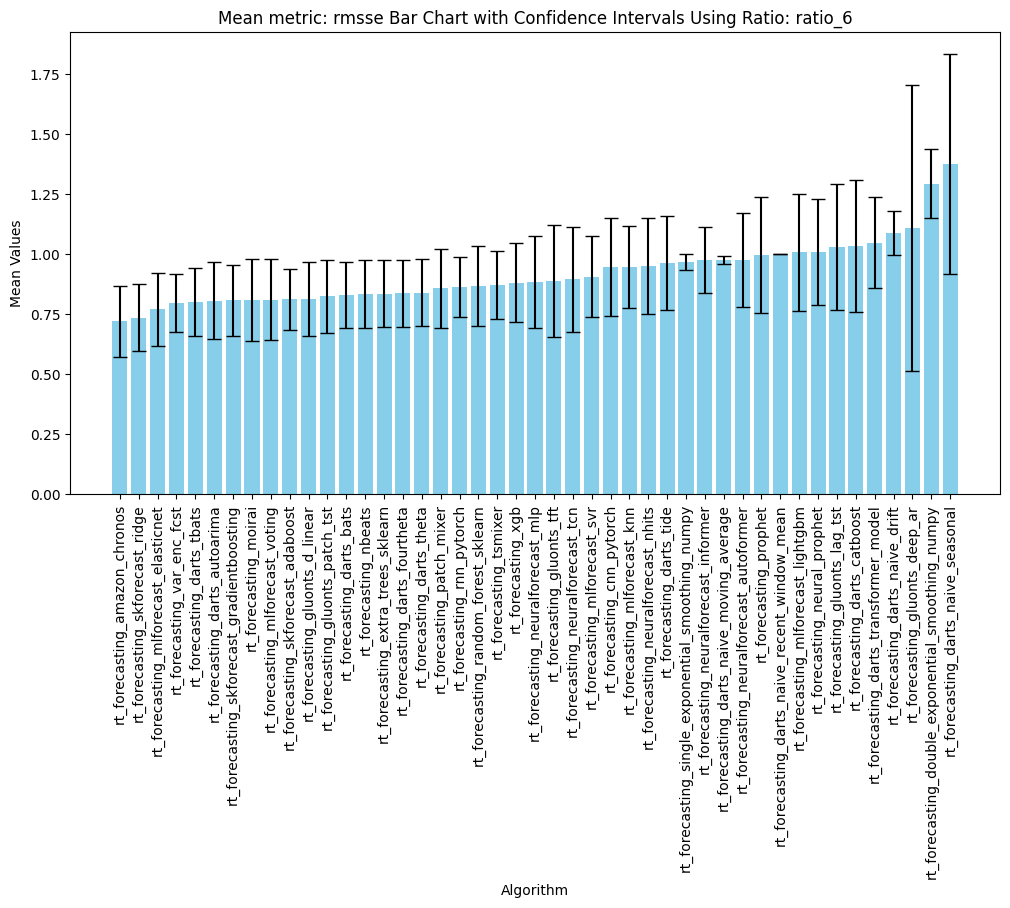

Should we reject H0 (i.e. is there a difference in the means) at the 90.0 % confidence level? True


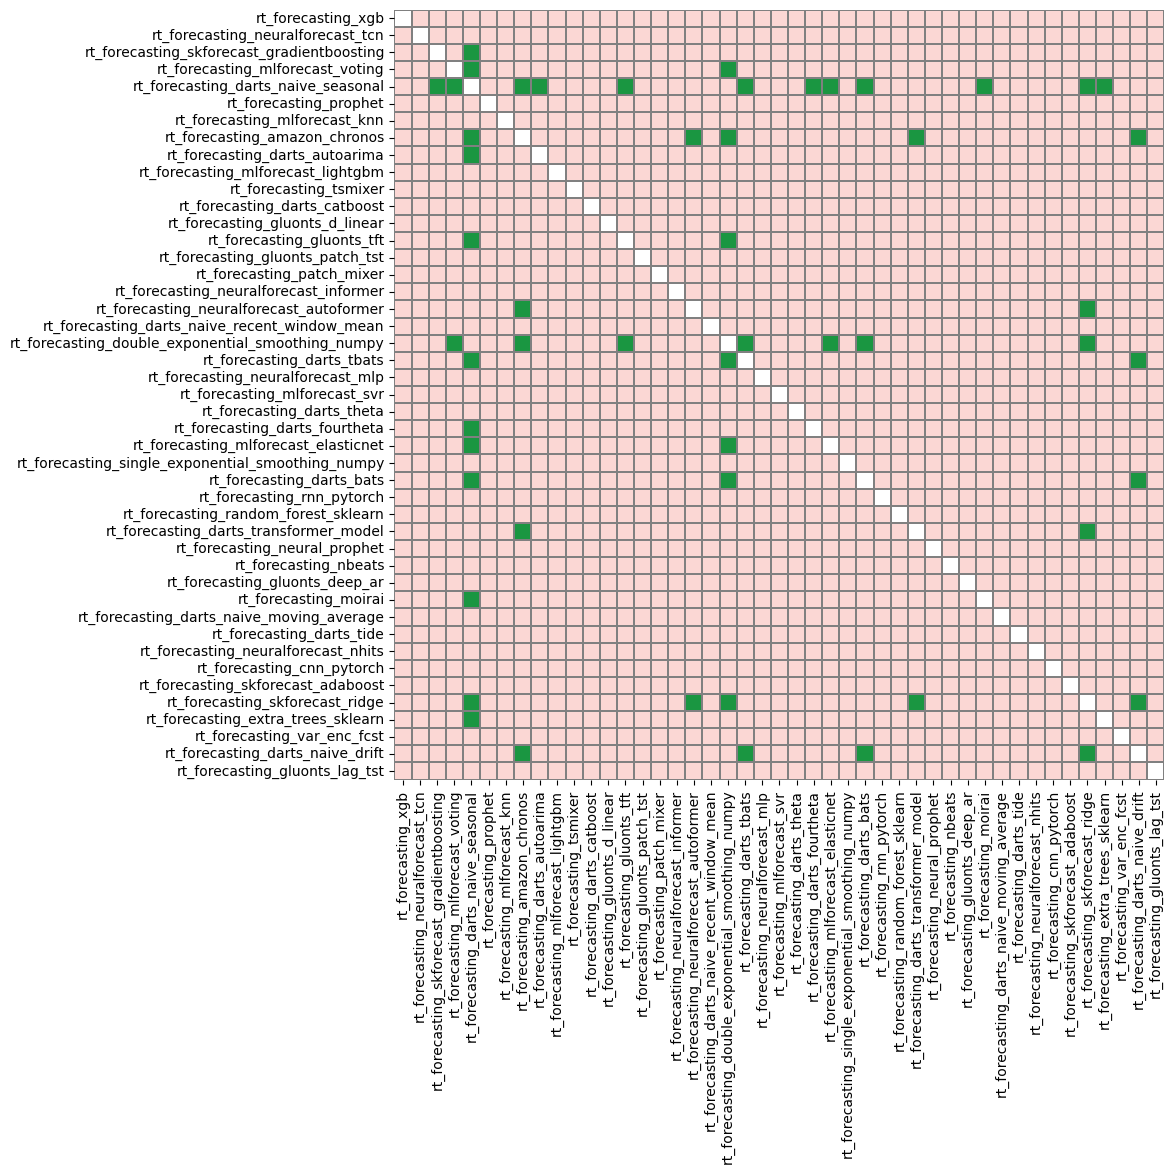

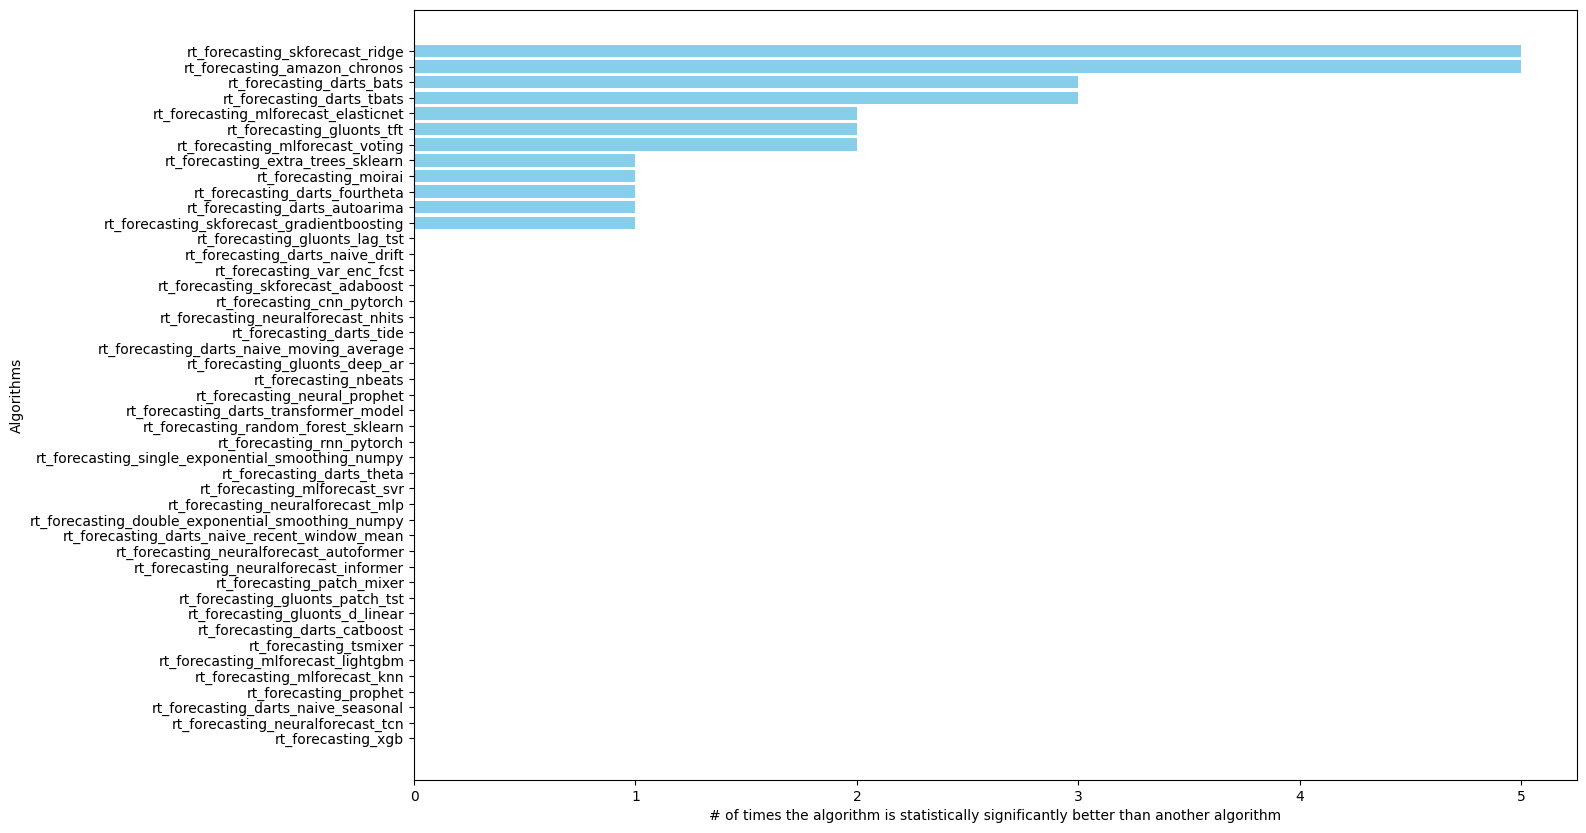

In [36]:
ratio = "ratio_6"
metric = "rmsse"
alpha= .1

generate_stats(df, ratio, metric, alpha)

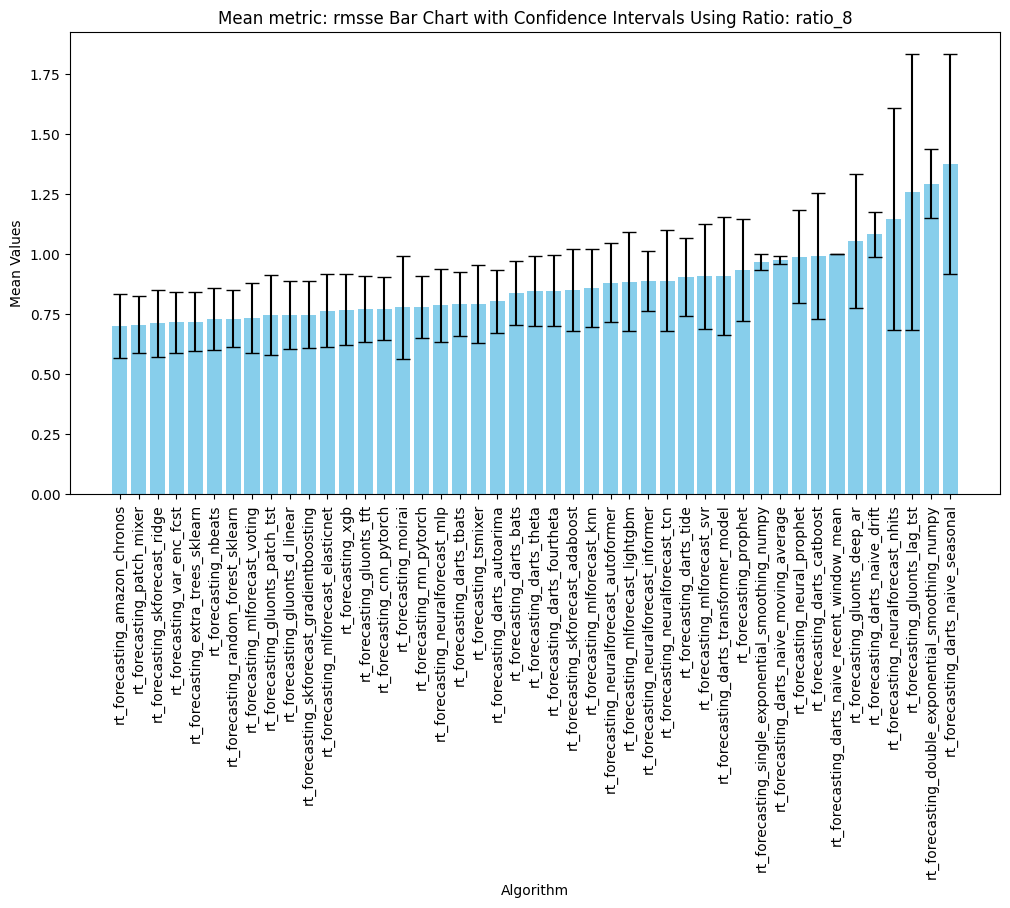

Should we reject H0 (i.e. is there a difference in the means) at the 90.0 % confidence level? True


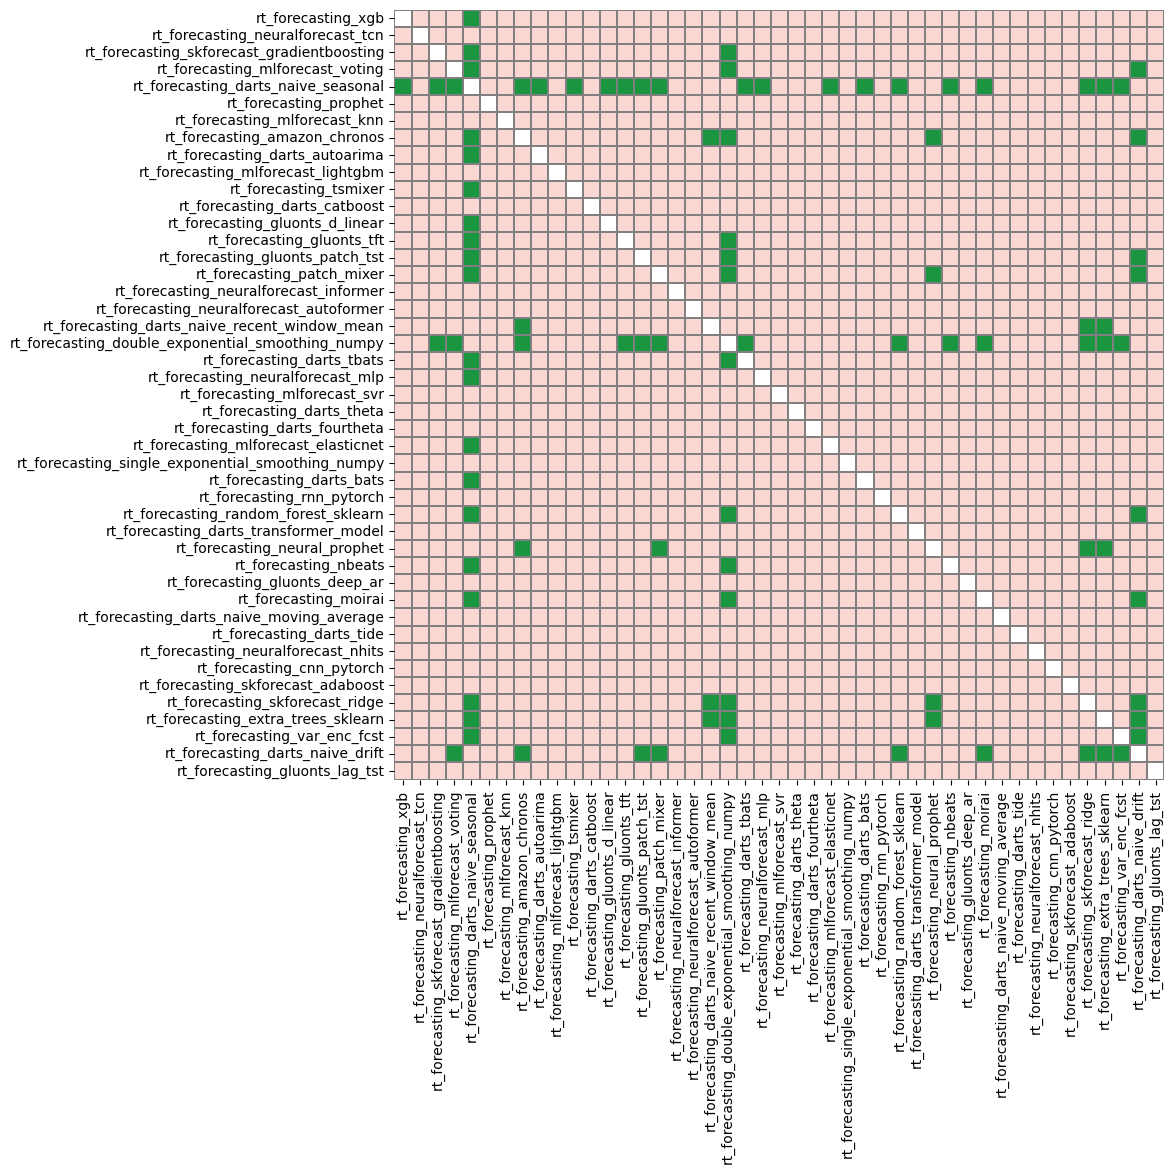

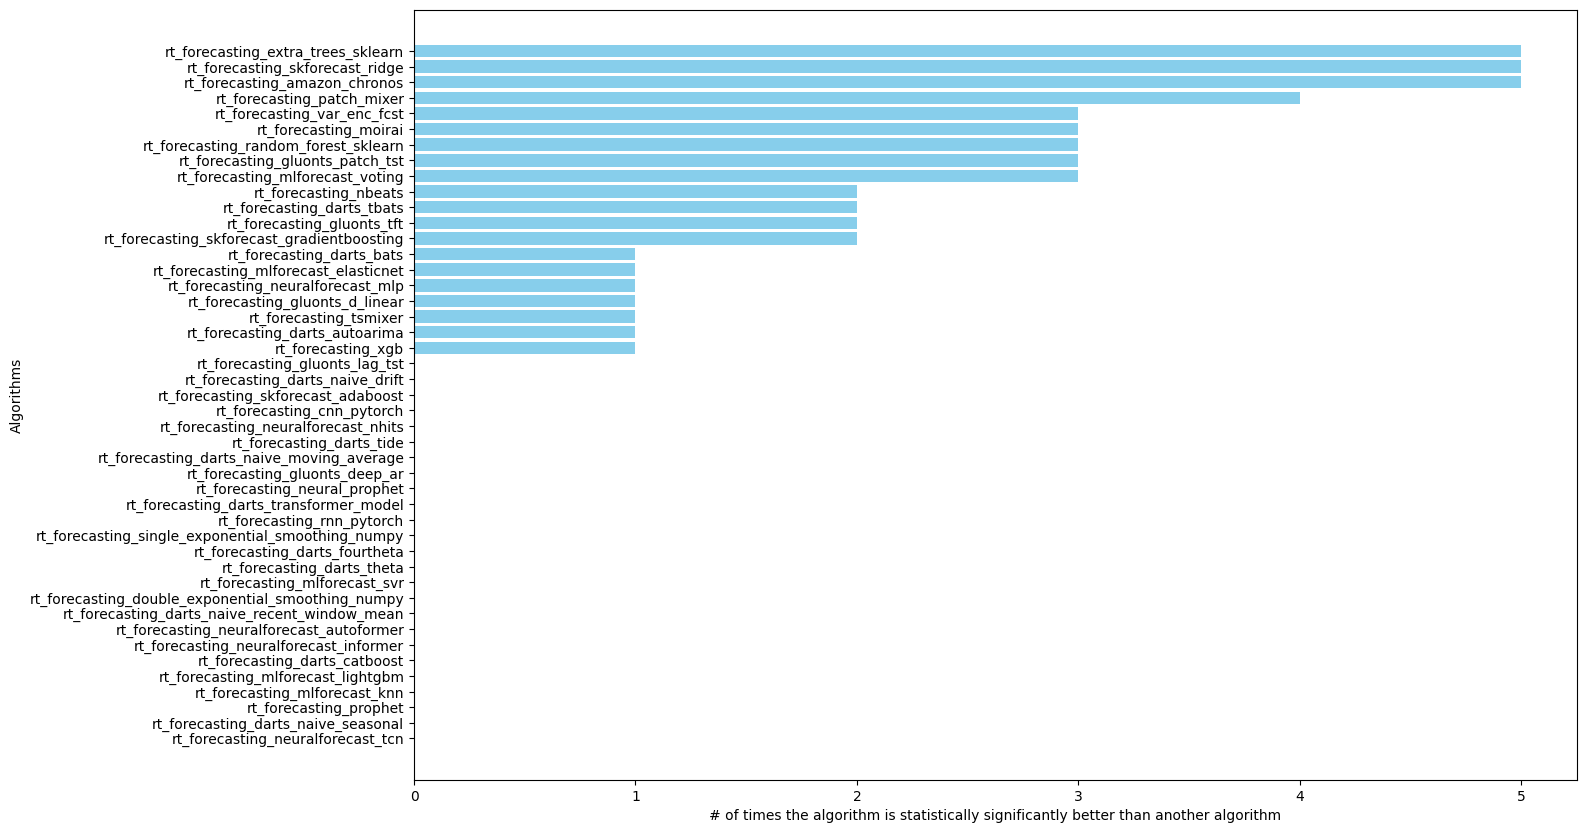

In [37]:
ratio = "ratio_8"
metric = "rmsse"
alpha= .1

generate_stats(df, ratio, metric, alpha)

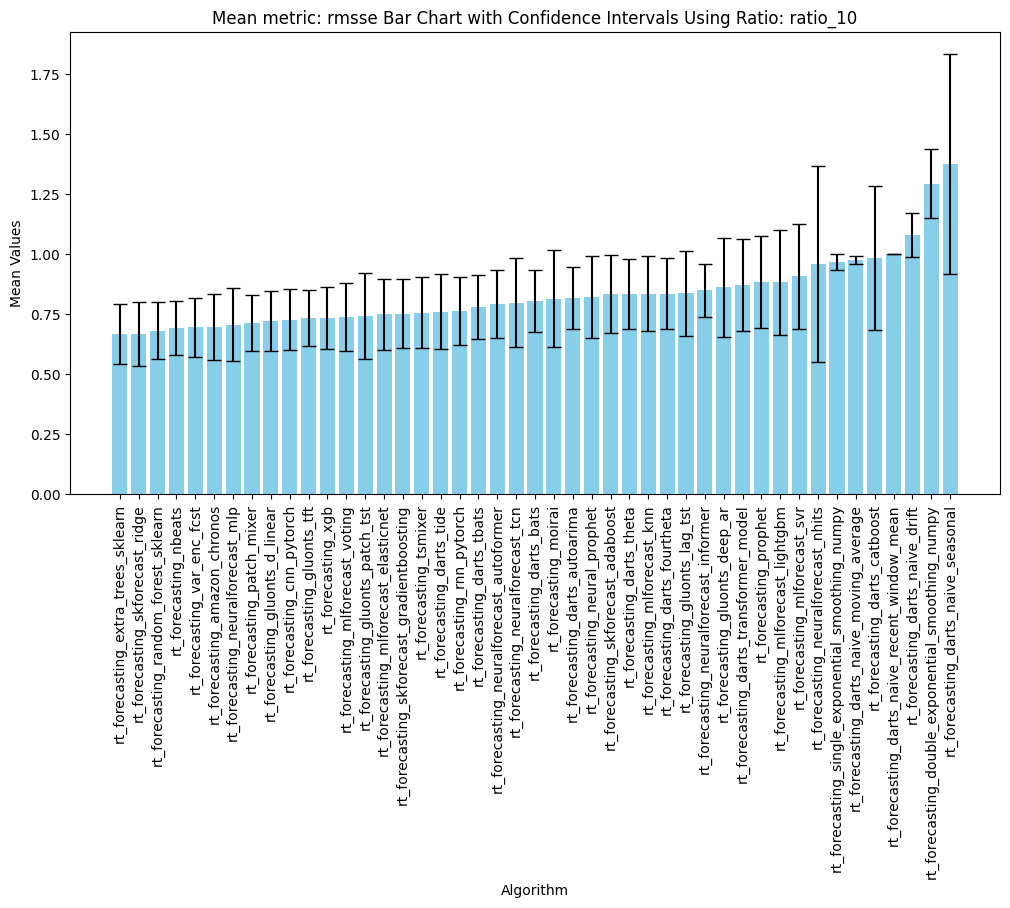

Should we reject H0 (i.e. is there a difference in the means) at the 90.0 % confidence level? True


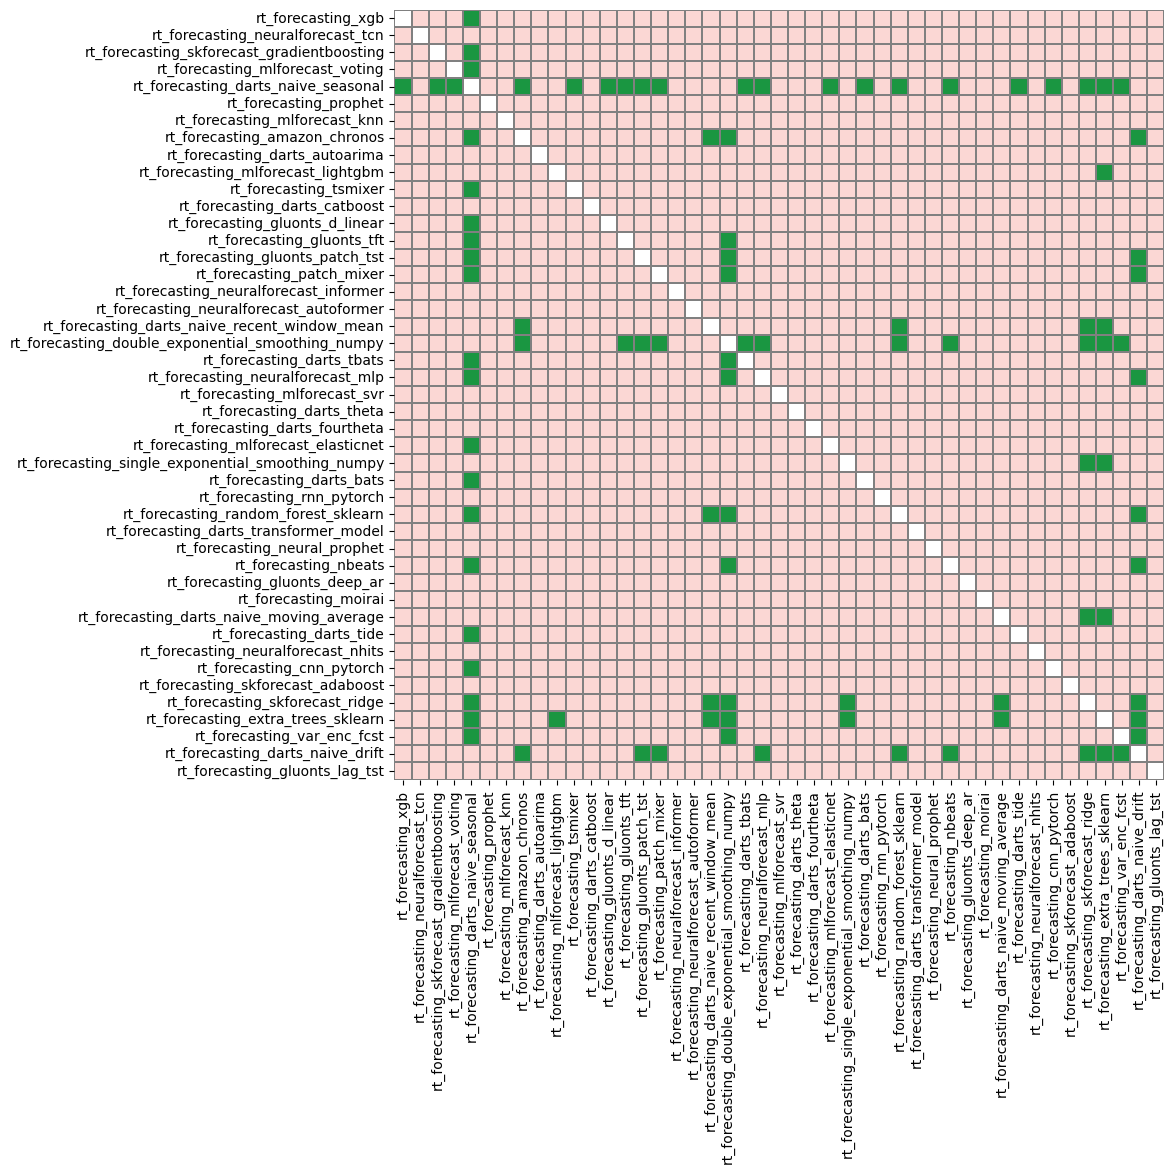

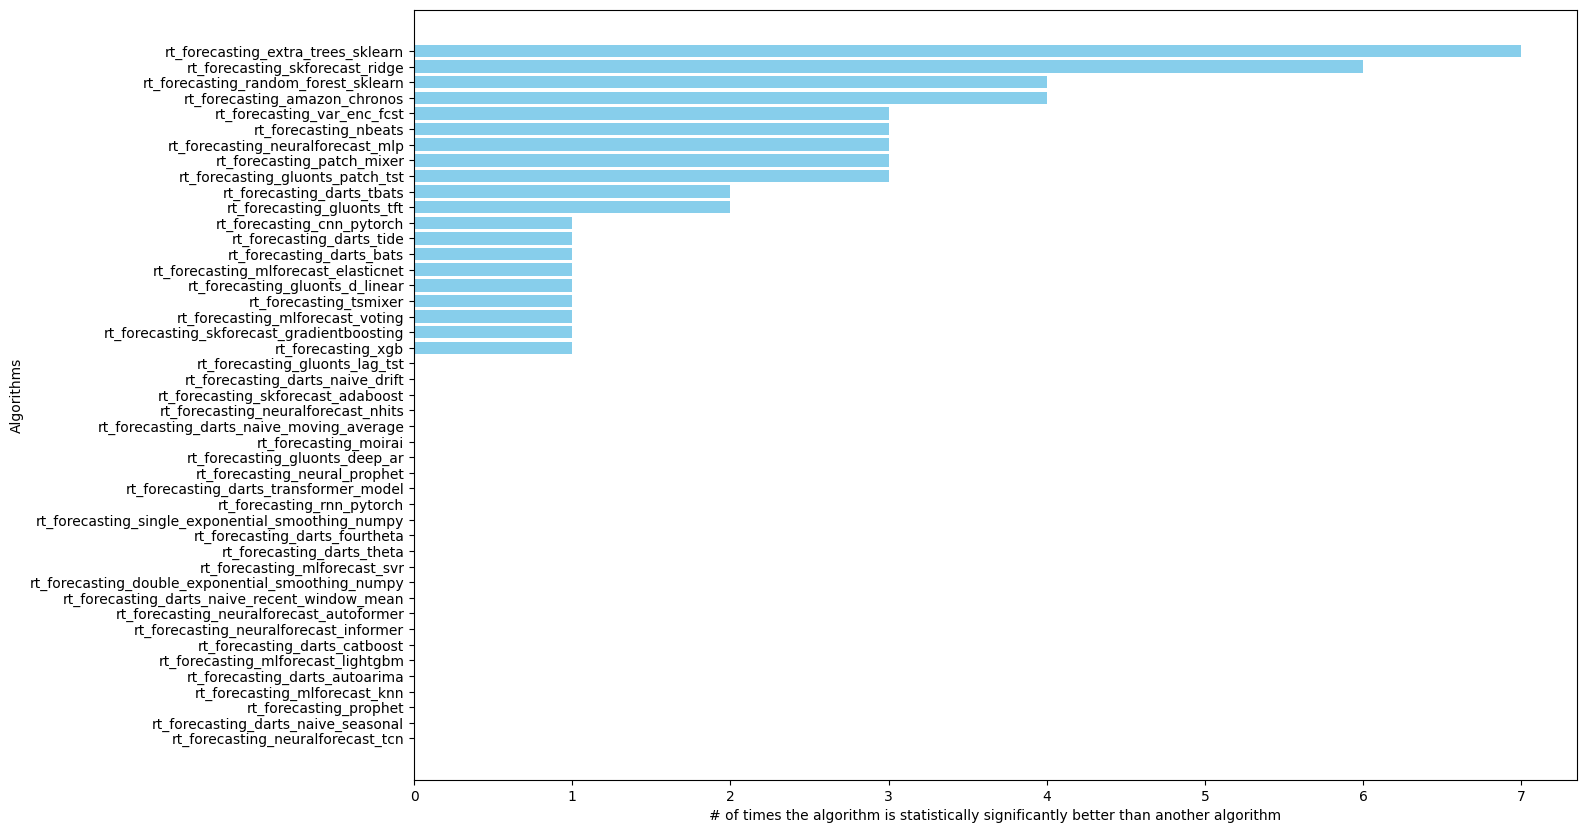

In [38]:
ratio = "ratio_10"
metric = "rmsse"
alpha= .1

generate_stats(df, ratio, metric, alpha)

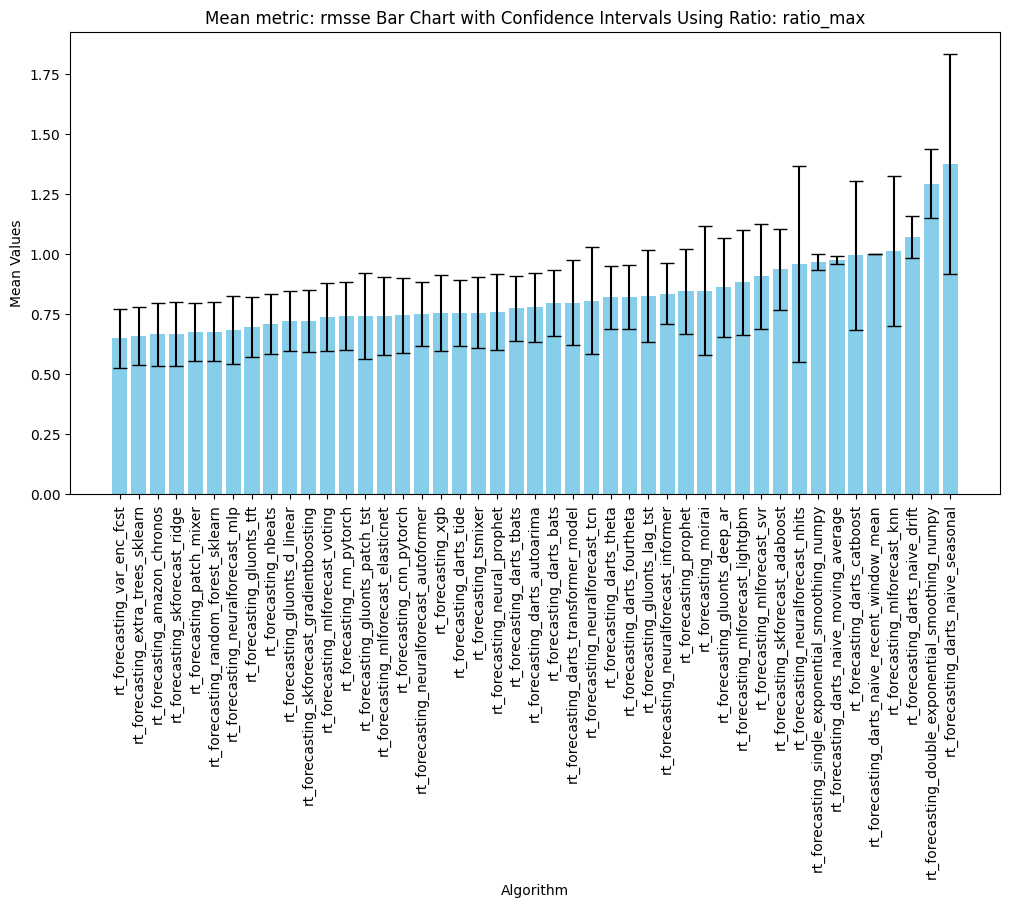

Should we reject H0 (i.e. is there a difference in the means) at the 90.0 % confidence level? True


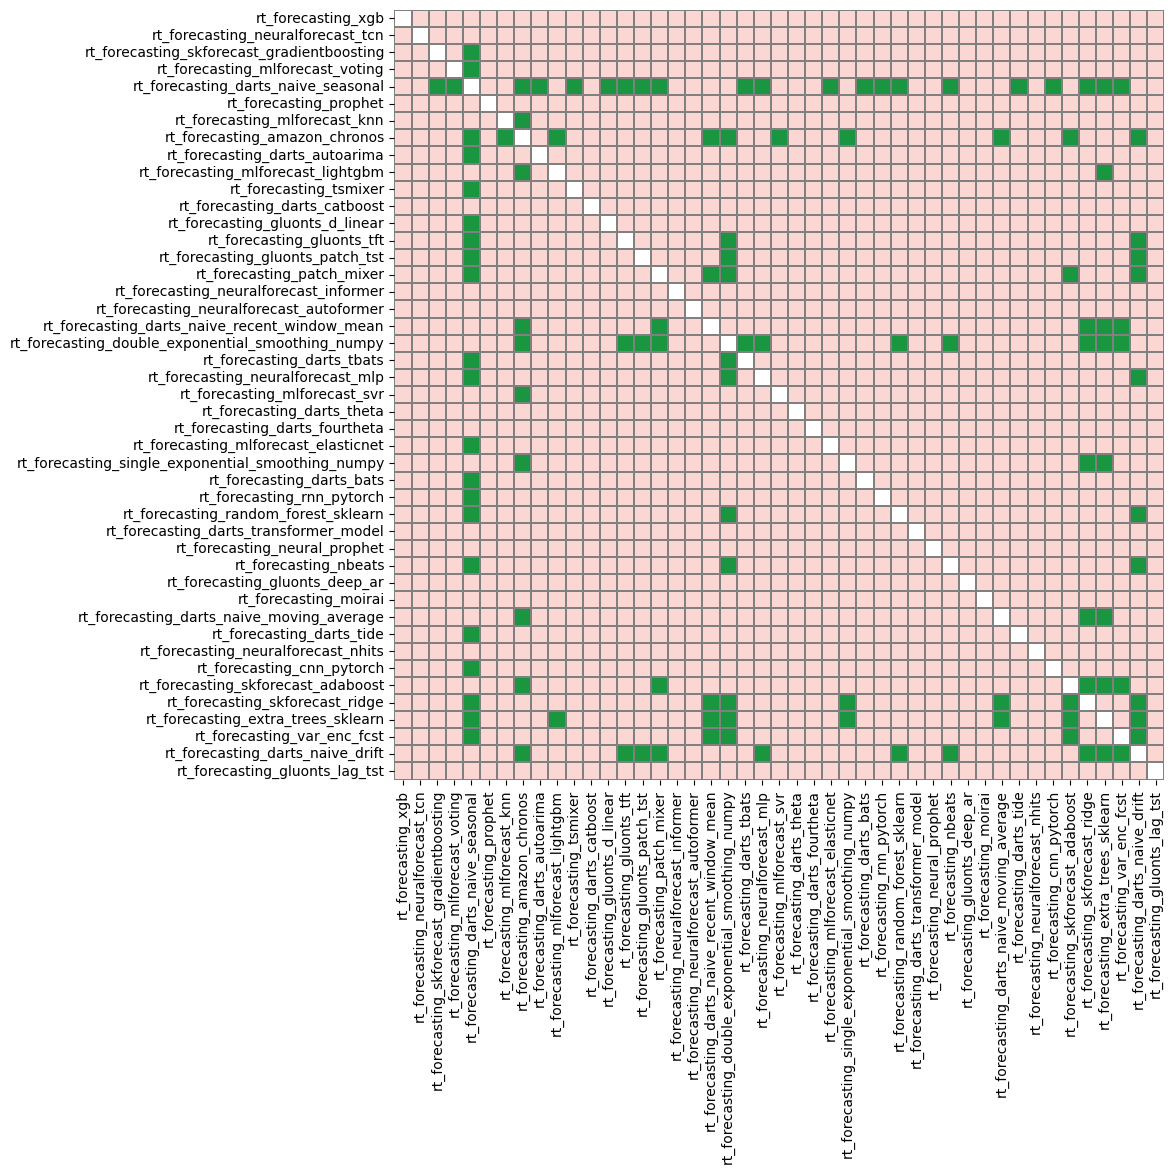

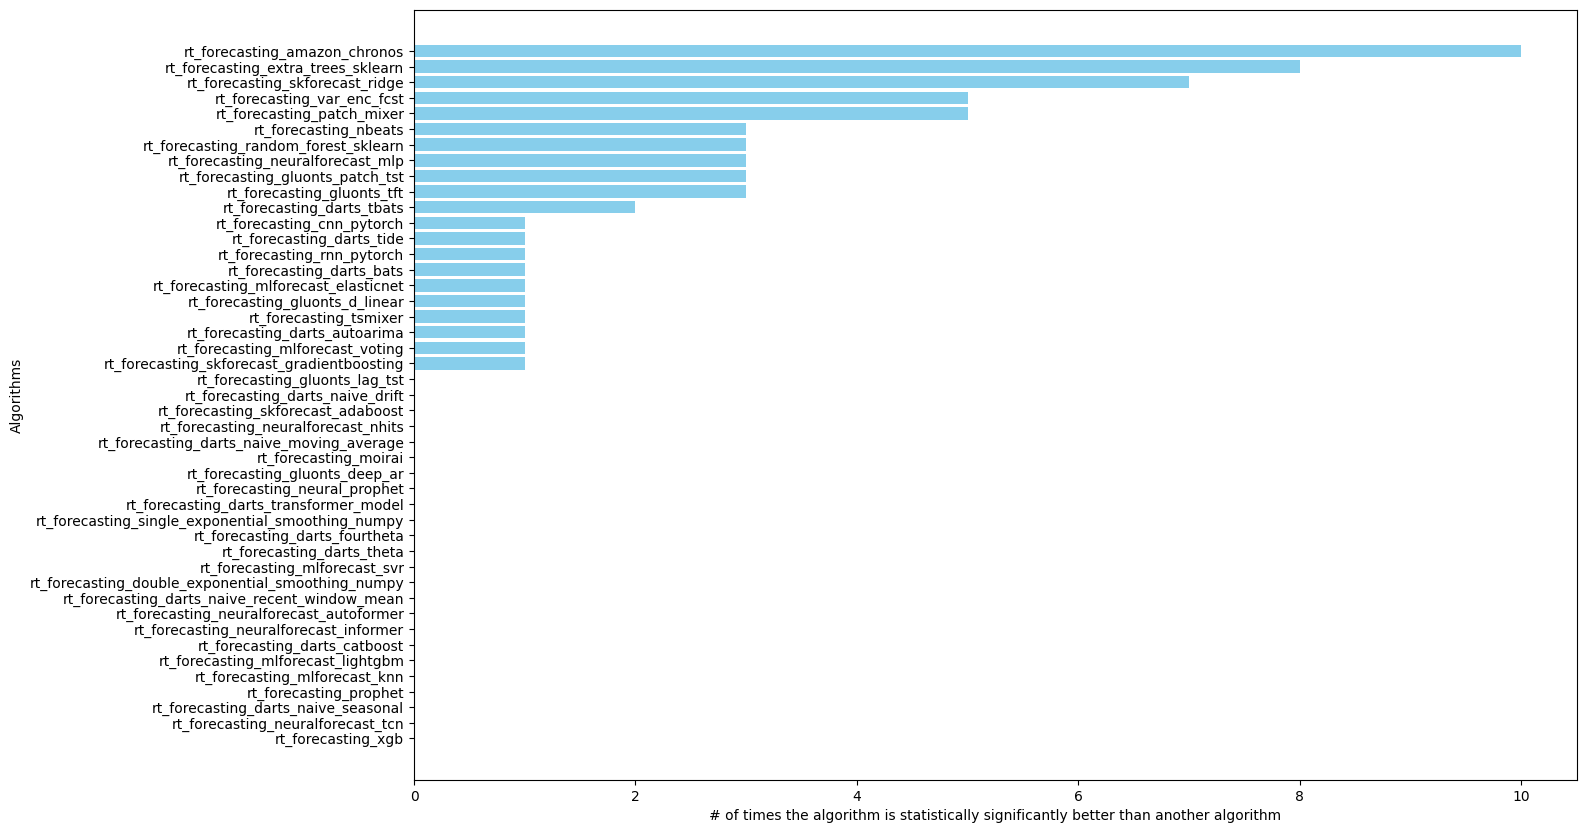

In [39]:
ratio = "ratio_max"
metric = "rmsse"
alpha= .1

generate_stats(df, ratio, metric, alpha)